## Instructions
It is highly recommended that you run this notebook in Colab.

Please install the libraries and data by running the cells below.  

Please upload the av-angry.m4a file into the contents folder of you Colab notebook.


Then you can proceed to run the rest of the notebook.

___
### Imports
___

#### Import libraries and data

*KaggleHub is a Python package that provides a simple API to access Kaggle resources anywhere, including Colab.

In [143]:
# uncomment and run if imports below return errors.
# !pip install ffmpeg
# !pip install kagglehub
# !pip install librosa
# !pip install pydub
# !pip install evaluate
# !pip install pycaret
# !pip install tensorflow

import glob
import IPython.display as ipd
import kagglehub
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib as Path
import pickle
import soundfile as sf
import seaborn as sns
import torch
import tensorflow as tf

from pathlib import Path
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModel
from transformers import TFAutoModelForAudioClassification
from transformers import HubertForCTC, AutoProcessor
from transformers import pipeline, EarlyStoppingCallback
from transformers import TrainingArguments, Trainer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
  Created wheel for pipreqsnb: filename=pipreqsnb-0.2.4-py3-none-any.whl size=4128 sha256=36ea3854721282fce2f236a08a6944041e43d8b62a68dbc34eb7f4b7a36bb7cb
  Stored in directory: /root/.cache/pip/wheels/a6/f6/b8/5bd85cc669a8f4985ea596345127d33cf3569b037cf7e1194d
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=529616f99082bd7359befc58d3f061bdabc5b753a16820b048d2559372bb08f7
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built pipreqsnb docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not 

In [2]:
# Define the path to your data set
# This can vary depending if you are working in colab or jupyter lab
path_rav = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
# indexed in third number group of file name.
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
print("Path to dataset files:", path_rav)

100%|██████████| 429M/429M [00:07<00:00, 62.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [3]:
# Path to Toronto
path_tor = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
# anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral
# labeled folders with each emotion as a full word at the end of the file name, supries abbreviated to ps.
# 2 copies of all files thsi si noted and accounted for when extracting the file names into a list for processing.
print("Path to dataset files:", path_tor)

100%|██████████| 428M/428M [00:05<00:00, 74.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1


In [4]:
# Path to Surrey
path_sur = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
# Male only
# Emotions anger, disgust, fear, happiness, sadness and surprise, neutral. Unlabeled
print("Path to dataset files:", path_sur)

100%|██████████| 107M/107M [00:00<00:00, 189MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1


In [5]:
# Path to Crema-D
path_cre = kagglehub.dataset_download("ejlok1/cremad")
# six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad)
# file name labeled with first 3 letters of each emotion
# the emotion code is index 9 in file name
print("Path to dataset files:", path_cre + '/AudioWAV')

100%|██████████| 451M/451M [00:07<00:00, 62.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1/AudioWAV


___
### EDA
___

#### Audiowave visulizations of two RAVDESS data files

Audio file to play, so we know what is being visualized.

Visualizing to illustrate relationships between files and modes of digital representation.

Renderings as Spectogram,
Mel-Frequencey Spectogram, Fourier-Spectogram and Chromagraph.

In [6]:
# import two wav files for some EDA

single_file1 = (path_rav + '/Actor_01/03-01-01-01-01-01-01.wav') #this emotion is neutral

single_file2 = (path_rav + '/Actor_20/03-01-08-02-02-02-20.wav') #this emotion is suprise

In [7]:
# Converts to mono by averaging all channels
y, sr = librosa.load(single_file1, sr=None)

In [8]:
y2, sr = librosa.load(single_file2, sr=None)

In [9]:
ipd.Audio(single_file1)

In [10]:
ipd.Audio(single_file2)

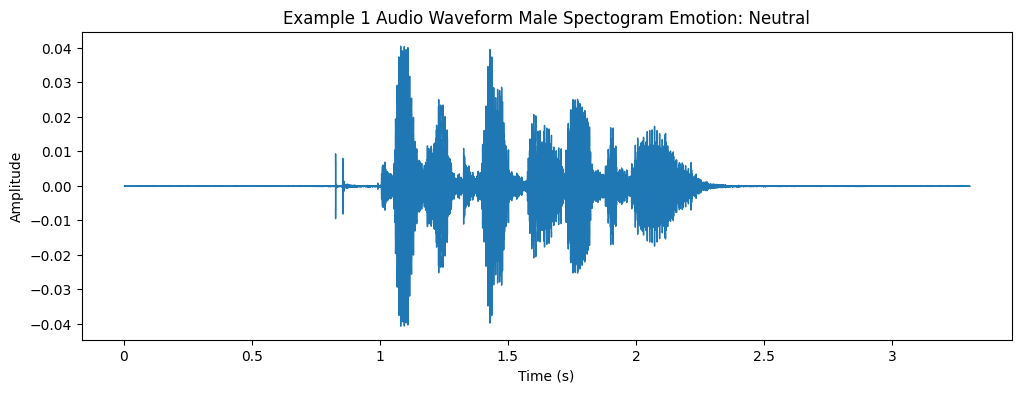

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Example 1 Audio Waveform Male Spectogram Emotion: Neutral')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show();

plt.savefig('Example_1_Male_Spectogram_Emotion: Neutral.png')
# FIGURE OUT HOW TO DESCRIBE WHAT YOU ARE SEEING


# Optional Arguments for plt.savefig():
# dpi: Sets the resolution of the image in dots per inch
# (e.g., plt.savefig("my_plot.png", dpi=300) for higher resolution).
# bbox_inches='tight': Removes any extra whitespace around the plot in the saved image.
# transparent=True: Makes the background of the saved image transparent.
# format: Explicitly specifies the file format (e.g., plt.savefig("my_plot", format="png")
# - though the extension usually suffices).

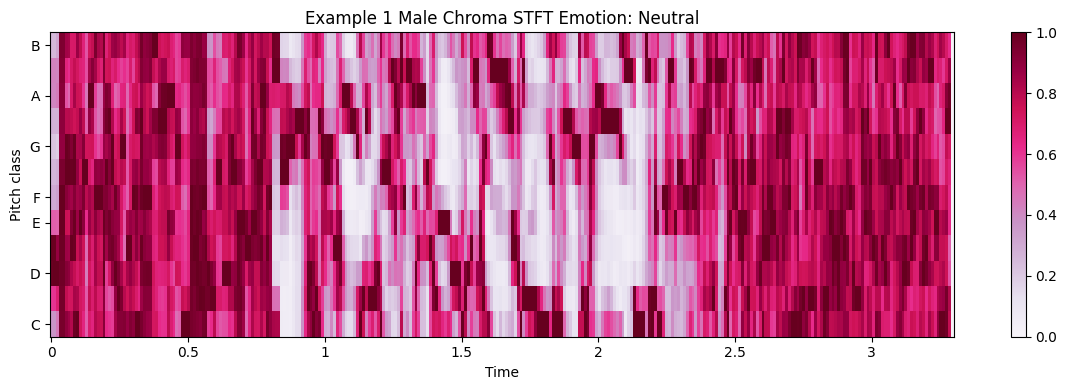

<Figure size 640x480 with 0 Axes>

In [12]:
# Computing chromagram
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Ploting chromagram
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr, cmap='PuRd')
plt.colorbar()
plt.title('Example 1 Male Chroma STFT Emotion: Neutral')
plt.tight_layout()
plt.show();

plt.savefig('Example_1_Male_ChromaSTFT_Emotion: Neutral.png')

In [13]:
# Compute the Mel-scaled spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibels
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

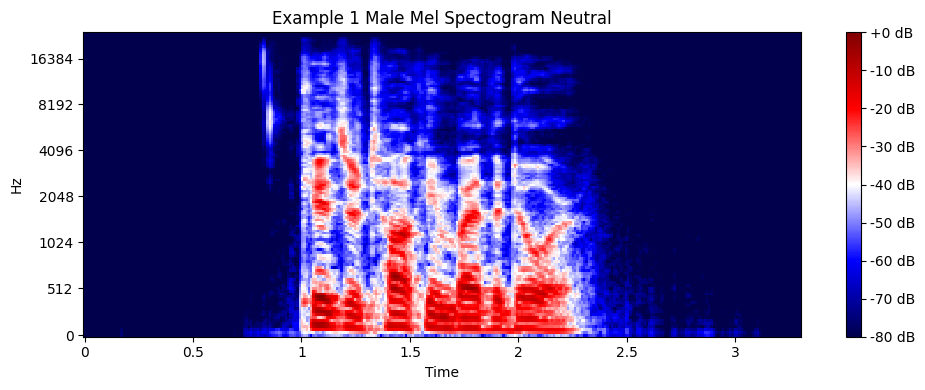

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap = 'seismic')
plt.colorbar(format='%+2.0f dB')
plt.title('Example 1 Male Mel Spectogram Neutral')
plt.tight_layout()
plt.show()

plt.savefig('Example_1_Male_Mel_Spectogram_Neutral.png')
# FIGURE OUT HOW TO DESCRIBE WHAT YOU ARE SEEING

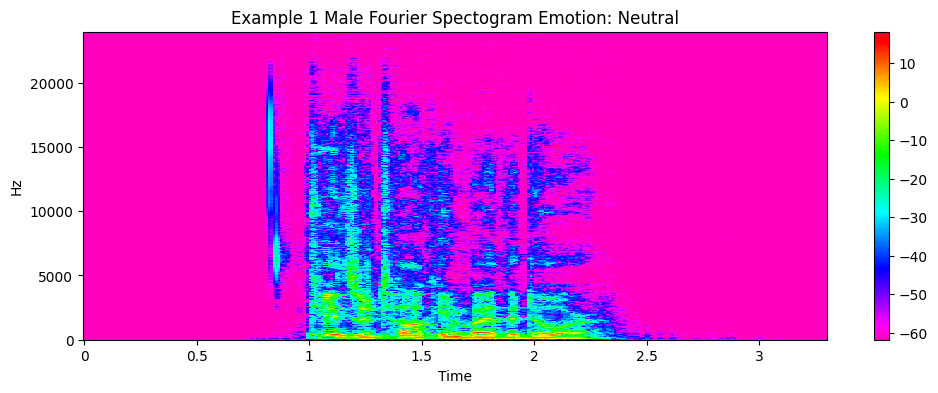

In [15]:
# Convert with Fourier transform
y_a = librosa.stft(y)
y_a_ft = librosa.amplitude_to_db(abs(y_a))

# Plot
plt.figure(figsize=(12, 4))
librosa.display.specshow(y_a_ft, sr=sr,x_axis='time', y_axis='hz', cmap = 'gist_rainbow_r')
plt.title('Example 1 Male Fourier Spectogram Emotion: Neutral')
plt.colorbar();

plt.savefig('Example_1_Male_Actor_1_Fourier_Spectogram_Neutral.png')

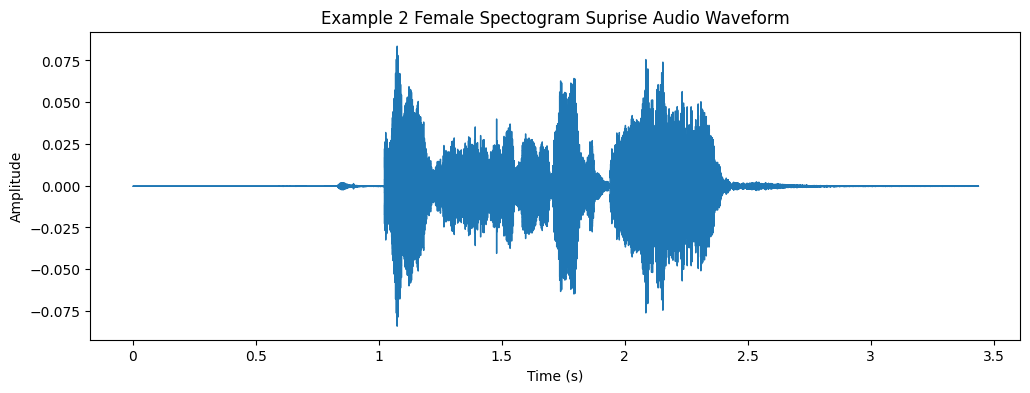

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y2, sr=sr)
plt.title('Example 2 Female Spectogram Suprise Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show();

plt.savefig('Example_2_Female_Spectogram_Suprise.png')
# FIGURE OUT HOW TO DESCRIBE WHAT YOU ARE SEEING

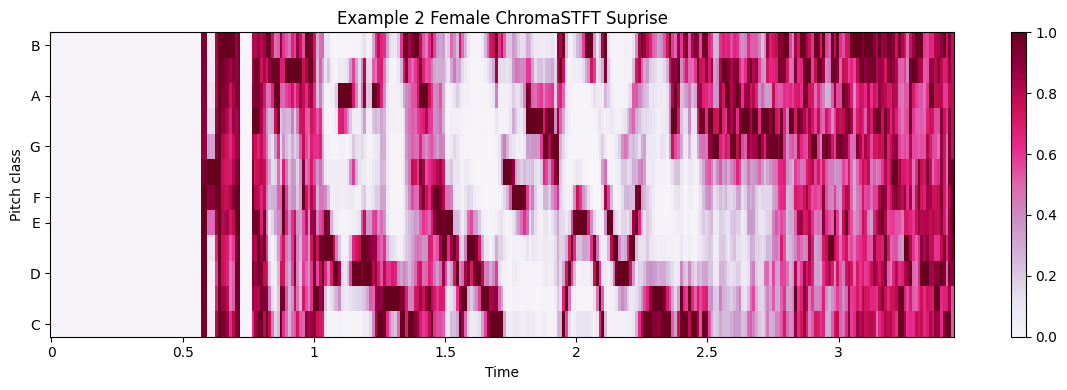

<Figure size 640x480 with 0 Axes>

In [17]:
# Compute the chromagram using chroma_stft
chroma = librosa.feature.chroma_stft(y=y2, sr=sr)

# Plot the chromagram
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr, cmap='PuRd')
plt.colorbar()
plt.title('Example 2 Female ChromaSTFT Suprise')
plt.tight_layout()
plt.show();

plt.savefig('Example_2_Female_ChromaSTFT_Suprise.png')

In [18]:
# Compute the Mel-scaled spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y2, sr=sr)

# Convert to decibels
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

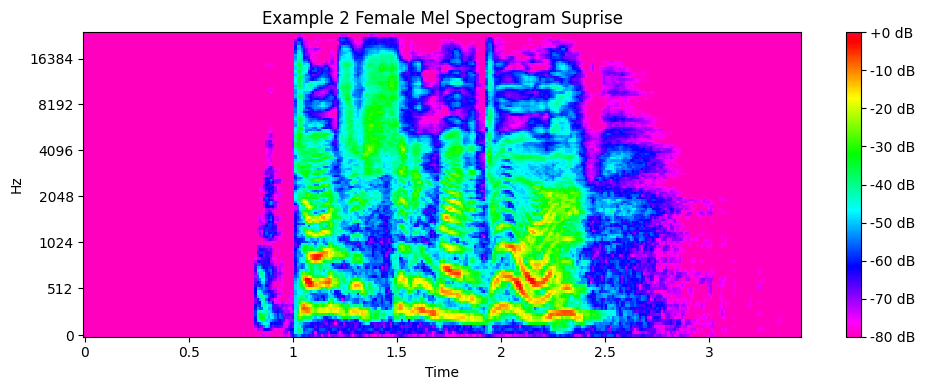

<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap = 'gist_rainbow_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Example 2 Female Mel Spectogram Suprise')
plt.tight_layout()
plt.show();

plt.savefig('Example_2_Female_Mel_Spectogram_Suprise.png')
# FIGURE OUT HOW TO DESCRIBE WHAT YOU ARE SEEING

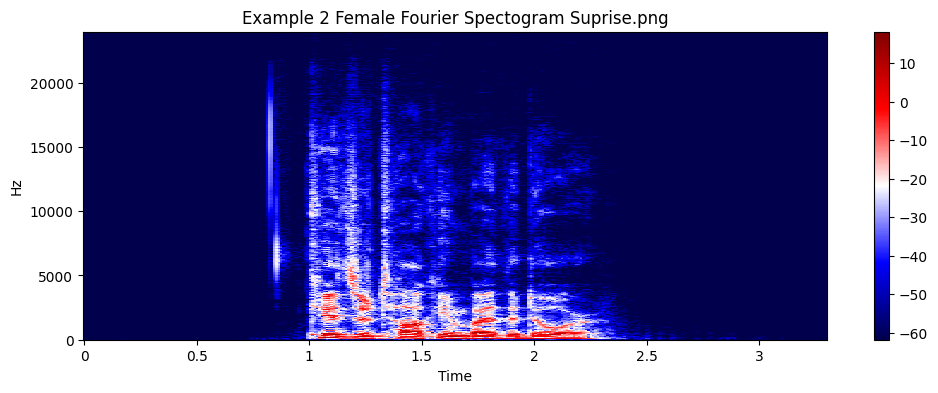

In [20]:
# Convert with Fourier transform
y_a = librosa.stft(y)
y_a_ft = librosa.amplitude_to_db(abs(y_a))

# Plot
plt.figure(figsize=(12, 4))
librosa.display.specshow(y_a_ft, sr=sr,x_axis='time', y_axis='hz', cmap = 'seismic')
plt.title('Example 2 Female Fourier Spectogram Suprise.png')
plt.colorbar();

plt.savefig('Example_2_Female_Fourier_Spectogram_Suprise.png')

In [25]:
# Looping through base directory (name as path varible in this instance) appending onto one list.

audio_list = []
for root, dir, files in os.walk(path_rav):
  for file in files:
    if file.endswith('.wav'):
      audio_list.append(os.path.join(root, file))

print(f'Found {len(audio_list)} WAV files')
len(audio_list)

Found 2880 WAV files


2880

In [26]:
audio_list[8]

'/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_21/03-01-05-01-02-02-21.wav'

In [27]:
# indexed in third number group of file name.
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

def pull_label_rav(audio_path_lst):
  labels = []
  emotions = {
      '01':'neutral',
      '02':'calm',
      '03':'happy',
      '04':'sad',
      '05':'angry',
      '06':'fearful',
      '07':'disgust',
      '08':'suprised'
  }
  for path in audio_path_lst:
        # Get the filename from the full path and remove the extension
        filename = os.path.basename(path)
        base_filename = os.path.splitext(filename)[0]

        # Split the filename by the '-' delimiter
        parts = base_filename.split('-')

        # Check if the list has enough parts before accessing the index
        if len(parts) >= 3:
            # The emotion code is the third part of the filename (index 2)
            emotion_code = parts[2]
            # Find the emotion string corresponding to the emotion code
            label = emotions.get(emotion_code)

            # Add the label to the list if it is found
            if label:
                labels.append(label)

  return labels



In [28]:
label_lst = pull_label_rav(audio_list) #output=labels

In [29]:
len(label_lst)

2880

In [30]:
# Looping through path_tor base directory

audio_tor = []
for root, dir, files in os.walk(path_tor):
    for file in files:
        if file.endswith('.wav'):
            # Append to audio_tor
            audio_tor.append(os.path.join(root, file))
            # Also append to audio_list
            audio_list.append(os.path.join(root, file))
    if len(audio_tor) == 2800:
        break

print(f'Found {len(audio_tor)} WAV files')
print(f'Total in audio_list: {len(audio_list)}')
print(f'Total in audio_tor: {len(audio_tor)}')

Found 2800 WAV files
Total in audio_list: 5680
Total in audio_tor: 2800


In [31]:
# Female only seven emotions: anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral
# labeled folders and full word last word of files, supries abbreviated to ps

def pull_label_tor(audio_path_lst):
  labels2 = []
  emotions2 = {
      'neutral':'neutral',
      'calm':'calm',
      'happy':'happy',
      'sad':'sad',
      'angry':'angry',
      'fear':'fearful',
      'disgust':'disgust',
      'ps':'suprised'
  }
  for path in audio_path_lst:
        # Get the filename from the full path and remove the extension
        filename = os.path.basename(path)
        base_filename = os.path.splitext(filename)[0]

        # Split the filename by the '_' delimiter
        parts = base_filename.split('_')

        # Check if the list has enough parts before accessing the index
        if len(parts) >= 3:
            # The emotion code is the third part of the filename (index 2)
            emotion_code = parts[2]
            # Find the emotion string corresponding to the emotion code
            label2 = emotions2.get(emotion_code)

            # Add the label to the list if it is found
            if label2:
                labels2.append(label2)
  return labels2

In [32]:
label_lst2 = pull_label_tor(audio_tor) #output = labels2

In [33]:
len(label_lst2)

2800

In [34]:
# Looping through path_sur base directory
audio_sur = []
for root, dir, files in os.walk(path_sur):
  for file in files:
    if file.endswith('.wav'):
      audio_sur.append(os.path.join(root, file))
      audio_list.append(os.path.join(root, file))

print(f'Found {len(audio_sur)} WAV files')
len(audio_list)

Found 480 WAV files


6160

In [35]:
audio_sur

['/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/JK_f09.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/KL_d09.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/DC_su09.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/JE_n08.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/JE_n29.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/DC_sa10.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/KL_f02.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/DC_d09.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/DC_

In [36]:
# Male only
# Emotions anger, disgust, fear, happiness, sadness and surprise, neutral. Unlabeled

def pull_label_sur(audio_path_lst):
  labels3 = []
  emotions3 = {
      'n':'neutral',
      'c':'calm',
      'h':'happy',
      'sa':'sad',
      'a':'angry',
      'f':'fearful',
      'd':'disgust',
      'su':'suprised'
  }
  for path in audio_path_lst:
        # Get the filename from the full path and remove the extension
        filename = os.path.basename(path)
        base_filename = os.path.splitext(filename)[0]

        # Split the filename by the '_' delimiter
        parts = base_filename.split('_')

        # Check if the list has enough parts before accessing the index
        if len(parts) >= 0 :
            # The emotion code is the third part of the filename (index 2)
            emotion_code = parts[1]
            emotion_code = emotion_code[:-2]
            emotion_name = emotion_code
            # Find the emotion string corresponding to the emotion code
            label3 = emotions3.get(emotion_name)

            # Add the label to the list if it is found
            if label3:
                labels3.append(label3)
  return labels3

In [37]:
label_lst3 = pull_label_sur(audio_sur)

In [38]:
len(label_lst3)

480

In [39]:
# Looping through path_cre base directory
audio_cre = []
for root, dir, files in os.walk(path_cre):
  for file in files:
    if file.endswith('.wav'):
      audio_cre.append(os.path.join(root, file))
      audio_list.append(os.path.join(root, file))

print(f'Found {len(audio_cre)} WAV files')
len(audio_list)

Found 7442 WAV files


13602

In [40]:
audio_list[5]

'/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_21/03-01-02-01-02-02-21.wav'

In [41]:
# six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad)
# file name labeled with first 3 letters of each emotion
# the emotion code is index 9 in file name

def pull_label_cre(audio_path_lst):
  labels4 = []
  emotions4 = {
      'NEU':'neutral',
      'CAL':'calm',
      'HAP':'happy',
      'SAD':'sad',
      'ANG':'angry',
      'FEA':'fearful',
      'DIS':'disgust',
      'SUP':'suprised'
  }
  for path in audio_path_lst:
        # Get the filename from the full path and remove the extension
        filename = os.path.basename(path)
        base_filename = os.path.splitext(filename)[0]

        # Split the filename by the '_' delimiter
        parts = base_filename.split('_')

        # Check if the list has enough parts before accessing the index
        if len(parts) >= 2:
            # The emotion code is the third part of the filename (index 2)
            emotion_code = parts[2]
            # Find the emotion string corresponding to the emotion code
            label4 = emotions4.get(emotion_code)

            # Add the label to the list if it is found
            if label4:
                labels4.append(label4)
  return labels4

In [42]:
label_lst4 = pull_label_cre(audio_cre)

In [43]:
len(label_lst4)

7442

In [44]:
# CONCATENATE ALL LABELS ONTO ONE LIST IN ORDER
labels_master = label_lst + label_lst2 + label_lst3 + label_lst4
len(labels_master)

13602

In [45]:
# Confiming list format is correct for duration function.
audio_list[0:5]

['/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_21/03-01-06-01-01-01-21.wav',
 '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_21/03-01-02-02-02-01-21.wav',
 '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_21/03-01-08-02-02-02-21.wav',
 '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_21/03-01-04-01-02-01-21.wav',
 '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_21/03-01-07-01-01-01-21.wav']

In [46]:
# CREATE A DATAFRAME WITH COLUMN OF EMOTION LABELS: labels_master AND COLUMN OF FILE PATHS: audio_list

data = {'labels': labels_master, 'paths': audio_list}


In [47]:
df = pd.DataFrame()
df['labels'] = labels_master
df['paths'] = audio_list

df.head()
df.to_csv('ser-labels-paths.csv', index=False)

In [48]:
df['labels'].value_counts()

,count
labels,
fearful,2115
sad,2115
angry,2115
disgust,2115
happy,2115
neutral,1799
suprised,844
calm,384


/tmp/ipython-input-1529224469.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['labels'],  palette='Set2')


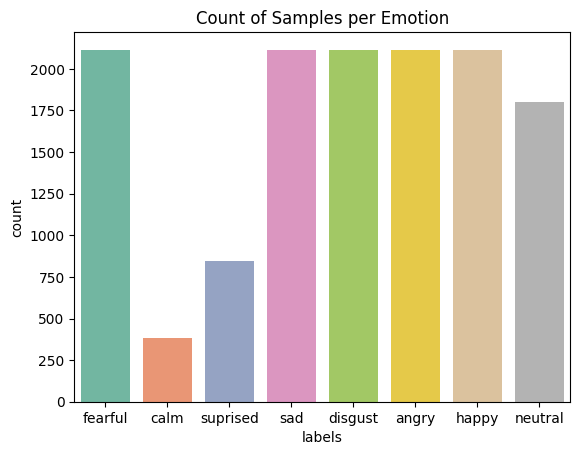

In [49]:
sns.countplot(x = df['labels'],  palette='Set2')

plt.title('Count of Samples per Emotion');
data = {'labels': labels_master, 'paths': audio_list}

df = pd.DataFrame(data)

df.head()
plt.savefig('Count of Samples per Emotion Label.png')

In [52]:
# data = {'labels': labels_master, 'paths': audio_list}

# df = pd.DataFrame(data)

# display waveplot
def waveshow(data, sr, emotion):
  plt.figure()
  plt.title(emotion, size=20)
  # librosa.display.waveshow(data, sr=sr)
  librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[2], label='Harmonic')
  librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')
  plt.show()


def spectogram(data, sr, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))
  plt.figure()
  plt.title(emotion, size=20)
  librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz', cmap='gist_rainbow_r')
  plt.colorbar


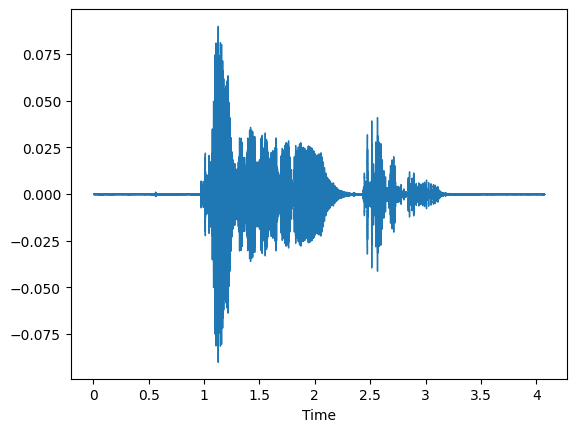

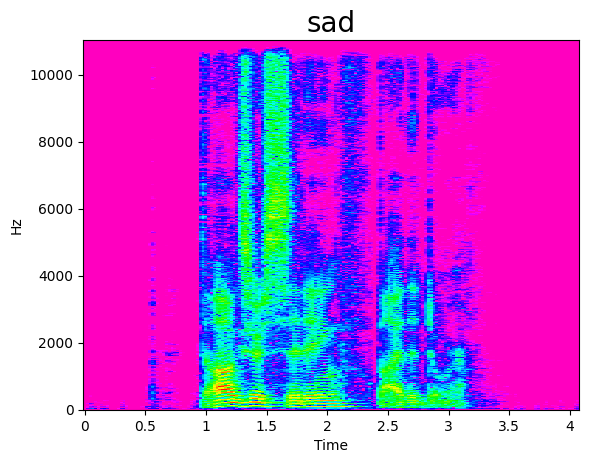

In [58]:
emotion = df['labels'][3]
path = df['paths'][3]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data)
plt.savefig('Example_3_Male_Spectogram_Sad.png')
spectogram(data, sampling_rate,emotion)
plt.savefig('Example_3_Male_Mel_Spectogram_Sad.png')

ipd.Audio(path)

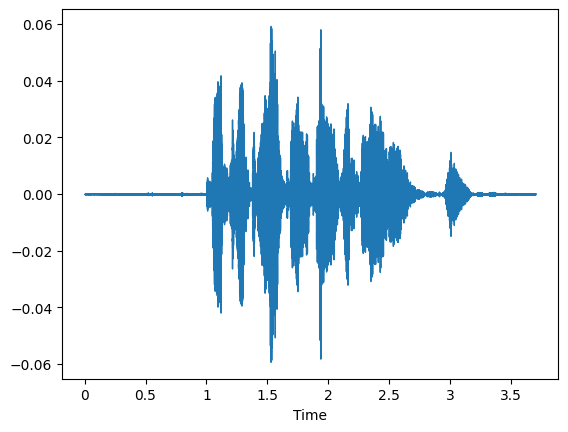

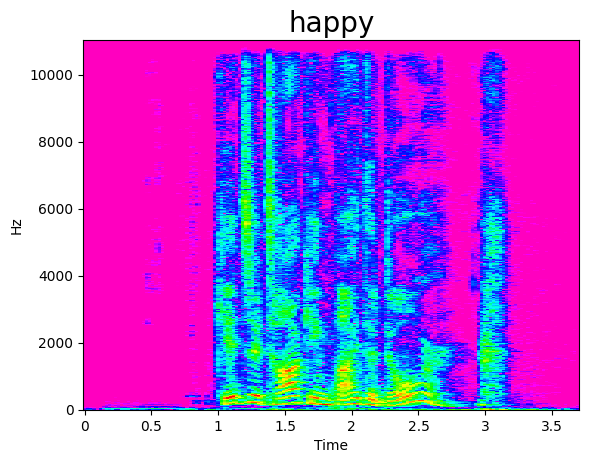

In [57]:
emotion = df['labels'][1329]
path = df['paths'][1329]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data)
plt.savefig('Example_4_Male_Spectogram_Happy.png')
spectogram(data, sampling_rate,emotion)
plt.savefig('Example_4_Male_Mel_Spectogram_Happy.png')

ipd.Audio(path)

In [59]:
def duration_report(aud_lst):
  ''' function to take our list of audio files and return their min, max and mean durations '''
  dur = []
  for file_path in aud_lst:
    if not os.path.exists(file_path):
      print(f'{file_path} not found.')
      continue
    try:
      audio = AudioSegment.from_file(file_path)
      dur_sec = len(audio) / 1000.0
      dur.append(dur_sec)
    except Exception as e:
      print(f'{file_path} processing error')

  min_dur = min(dur)
  max_dur = max(dur)

  print(min_dur)
  print(max_dur)

In [60]:
# Calling the duration report function on audio_list, should return min and max duration of our wav files
# duration_report(audio_list)

---
# Modeling
---

The base model was constructed in this note book. Further iterations are in other notebooks.


---
Model 1: LSTM NN
---

Data preped in EDA section of notebook.

Steps:
1. Extract features and Normalize data, and vectorize for each observation
3. Train the model
4. Fit model with Test and store predictions
5. Performance Visualizations


Performance: Terrible


Images: Loss and Accuracy comparisons of Test and Preds for every model. Located in the images/VAL folder in repo.


In [191]:
# Feature Extraction
def extract_mfcc(filename):
  y, sr = librosa.load(filename, duration = 4.25, offset= 0.5)
  mfcc = np.mean(librosa.feature.mfcc(y=y, sr=30000, n_mfcc=40).T, axis=0) #changed SR to 16 to see if it imporved results
  return mfcc
# should be able to stack more features here

In [192]:
df.head()

,labels,paths
0,fearful,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1,calm,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
2,suprised,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
3,sad,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
4,disgust,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...


In [193]:
extract_mfcc(df['paths'][0])
# array values for input to model
# contains a compact, two-dimensional numerical representation of the audio's spectral and timbral characteristics.

array([-5.4149078e+02,  7.2813950e+01, -6.8795905e+00,  1.7200407e+01,
       -4.3867013e-01, -1.3521768e+01, -3.6793661e+00, -1.1005792e+01,
       -7.9458070e+00,  2.3868785e+00, -7.9424167e+00, -6.7503490e+00,
        3.6169519e+00, -4.2394586e+00, -6.3531041e+00, -1.2417667e+00,
       -4.7076292e+00, -2.6512432e+00, -6.5069804e+00, -3.9147673e+00,
       -4.2421775e+00, -1.0510073e+00, -2.8616138e+00,  5.3723103e-01,
       -3.3447225e+00, -2.6537166e+00, -1.5960683e+00, -2.7766573e+00,
       -3.9373727e+00, -6.6246891e-01, -2.1149144e+00, -1.6956612e+00,
       -3.4734161e+00, -1.6992555e+00, -3.7281699e+00, -2.9614205e+00,
       -3.3333015e+00, -3.4776139e-01, -2.5855899e+00,  1.1528982e+00],
      dtype=float32)

In [194]:
X_mfcc = df['paths'].apply(lambda x: extract_mfcc(x))

In [195]:
X_mfcc

,paths
0,"[-541.4908, 72.81395, -6.8795905, 17.200407, -..."
1,"[-572.0181, 78.43258, -2.0543537, 18.03334, 5...."
2,"[-491.42395, 50.781, -5.4391437, 9.266377, -4...."
3,"[-593.7088, 73.656784, 2.657466, 17.046774, -0..."
4,"[-525.9822, 67.63606, -6.361302, 14.816802, -0..."
...,...
13597,"[-344.9902, 144.6258, 5.4288526, 31.874163, -2..."
13598,"[-363.2434, 166.51271, 2.7624066, 33.99054, -1..."
13599,"[-393.72778, 149.74786, 0.023366868, 51.460762..."
13600,"[-394.3896, 143.55063, 12.628355, 32.7021, -18..."


In [196]:
np.save('mfccs_1600sr_data.npy', X_mfcc)

In [197]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(13602, 40)

In [198]:
# input split
X = np.expand_dims(X, -1)

In [199]:
X.shape
#should be 3 dimensional 1. Length of dataset, 2. Column length (should be 40) 3. Dimension length

(13602, 40, 1)

In [200]:
# Output column
encoder = OneHotEncoder()
le = LabelEncoder()

In [201]:
y_encoded = encoder.fit_transform(df[['labels']])
y_encoded

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13602 stored elements and shape (13602, 8)>

In [202]:
# to see what the labels are
encoder.get_feature_names_out()

array(['labels_angry', 'labels_calm', 'labels_disgust', 'labels_fearful',
       'labels_happy', 'labels_neutral', 'labels_sad', 'labels_suprised'],
      dtype=object)

In [203]:
y = y_encoded.toarray()
y.shape

(13602, 8)

In [204]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [206]:
# build the LSTM model
# validation split in the model itself, adding train test split after intial run
model_LSTM = Sequential([
    LSTM(123,return_sequences=False, input_shape=(40,1)), #this is the number of freatures we extracted from each observation
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax'),
])

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  #sparse_ and enc y for confusion matrix will not get in this notebook saved from prior run
# the sparse categorical was causing the isssue/would like to get this to run again as well.
model_LSTM.summary()
tf.keras.models.save_model(model_LSTM, 'first_lstm_model.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 123)            │        61,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,780 (280.39 KB)

 Trainable params: 71,780 (280.39 KB)

 Non-trainable params: 0 (0.00 B)

In [207]:
# adding early stopping into .fit()
early_stop = EarlyStopping(
      monitor='accuracy',  # Metric to monitor (e.g., validation loss)
      patience=5,          # Number of epochs with no improvement after which training will be stopped
      mode='min',          # 'min' for metrics that should decrease (like loss), 'max' for metrics that should increase (like accuracy)
      restore_best_weights=True # Restores model weights from the epoch with the best monitored value
    )

In [208]:
history = model_LSTM.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.1708 - loss: 2.0464 - val_accuracy: 0.1865 - val_loss: 1.9259
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.1957 - loss: 1.9492 - val_accuracy: 0.2435 - val_loss: 1.8296
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - accuracy: 0.2320 - loss: 1.8473 - val_accuracy: 0.2967 - val_loss: 1.7125
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.2867 - loss: 1.7354 - val_accuracy: 0.3937 - val_loss: 1.5437
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.3403 - loss: 1.5959 - val_accuracy: 0.4093 - val_loss: 1.4954
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - accuracy: 0.3794 - loss: 1.5318 - val_accuracy: 0.4198 - val_loss: 1.4338
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - accuracy: 0.3922 - loss: 1.4835 - val_accuracy: 0.4391 - val_loss: 1.3874
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.4106 - loss: 1.4567 - val_ac

Early stopping terminated the training at Epoch 6 and resulted in 30% accuracy and 1.78 loss so it was removed and rerun. It indicated that the original model was likely getting over fit.

In [209]:
y_pred = np.asarray(model_LSTM.predict(X_test)).argmax(axis=1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


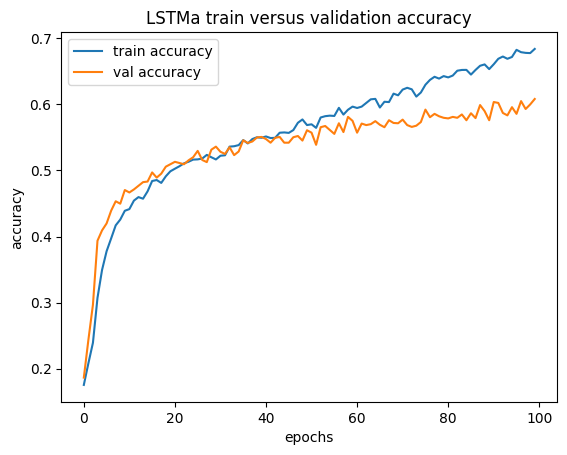

<Figure size 640x480 with 0 Axes>

In [211]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('LSTMa train versus validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show();
plt.savefig('LSTMa train versus validation accuracy')

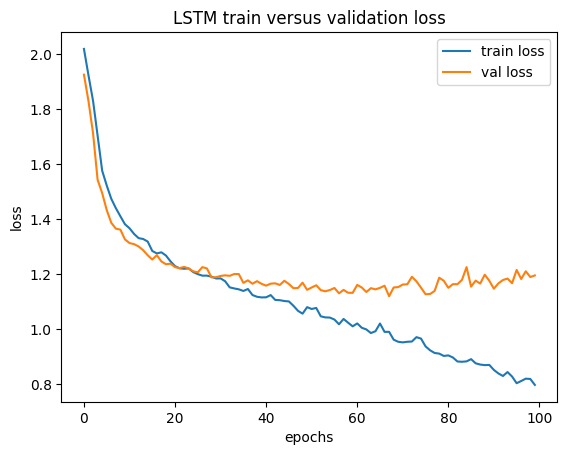

<Figure size 640x480 with 0 Axes>

In [212]:
epochs = list(range(100))
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('LSTM train versus validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show();
plt.savefig('LSTM train versus validation loss')

### Testing the model on new data, single inputs of a self recorded sample.

In [213]:
!sudo apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [214]:
m4a_fp = 'av-angry.m4a'

In [215]:
av_angry_extracted = extract_mfcc(m4a_fp)

/tmp/ipython-input-2038863478.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, duration = 4.25, offset= 0.5)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [216]:
av_angry_extracted = np.expand_dims(av_angry_extracted, -1)
av_angry_extracted.shape

(40, 1)

In [217]:
av_angry_extracted = np.array(av_angry_extracted)

In [220]:
model_LSTM = tf.keras.models.load_model('/content/first_lstm_model.h5')

In [221]:
self_rec_pred = model_LSTM.predict(av_angry_extracted)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


In [222]:
np.argmax(self_rec_pred)

np.int64(0)

In [223]:
predicted_labels = np.argmax(self_rec_pred, axis=1)
np.argmax(self_rec_pred)

np.int64(0)

## Refined data standardization and added to the extraction function
Alas perfromance decreased yet again. Left the function for reference but deleted the rest.

In [155]:
# # Feature Extraction
# def extract_features(filename, target_sr=30000, n_mfcc=40, target_length_samples=None):
#     """
#     Extracts multiple audio features from a single file.

#     Args:
#         filename (str): The path to the audio file.
#         target_sr (int): The target sample rate for resampling.
#         n_mfcc (int): The number of MFCC coefficients to extract.
#         target_length_samples (int, optional): The target length in samples.
#                                                 If None, no padding/trimming is applied.
    # Returns:
    #     np.ndarray: A concatenated feature vector.
    # """
    # # Loading file, resampling
    # y, sr = librosa.load(filename, sr=target_sr, duration=4.25, offset=0.5)

    # # Normalizing
    # y = librosa.util.normalize(y)

    # if target_length_samples:
    #     y = librosa.util.fix_length(y, size=target_length_samples)

    # mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # # Chroma
    # chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # # Mel-spectrogram
    # mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # # Aggregate each feature over time (taking the mean)
    # mfcc_mean = np.mean(mfcc.T, axis=0)
    # chroma_mean = np.mean(chroma.T, axis=0)
    # mel_mean = np.mean(mel.T, axis=0)

    # # Concatenate the aggregated features into a single vector
    # combined_features = np.concatenate((mfcc_mean, chroma_mean, mel_mean))

    # return combined_features